<a href="https://colab.research.google.com/github/fehnicchio/Triggo.ai/blob/main/triggo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ----------------------------------------
# Importações
# ----------------------------------------
import pandas as pd
import plotly.express as px
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
from geopy.distance import geodesic
import warnings
warnings.filterwarnings('ignore')

# ----------------------------------------
# 1.1 Importar arquivos CSV
# ----------------------------------------
datasets = {
    'orders': 'olist_orders_dataset.csv',
    'customers': 'olist_customers_dataset.csv',
    'order_items': 'olist_order_items_dataset.csv',
    'products': 'olist_products_dataset.csv',
    'sellers': 'olist_sellers_dataset.csv',
    'payments': 'olist_order_payments_dataset.csv',
    'reviews': 'olist_order_reviews_dataset.csv',
    'category_translation': 'product_category_name_translation.csv',
    'geolocation': 'olist_geolocation_dataset.csv'
}

data = {}
for name, file in datasets.items():
    try:
        data[name] = pd.read_csv(f'data/{file}')
        print(f' {file} carregado')
    except FileNotFoundError:
        print(f' {file} não encontrado')
        data[name] = pd.DataFrame()

# Verificar arquivos essenciais
essential_files = ['orders', 'customers', 'order_items']
for file in essential_files:
    if data[file].empty:
        raise SystemExit(f'Erro crítico: Arquivo {file} não encontrado!')

# ----------------------------------------
# 1.2 Processamento de Geolocalização
# ----------------------------------------
def process_geolocation(df_geo):
    """Limpa e agrupa coordenadas por CEP"""
    # Filtrar coordenadas dentro do Brasil
    df_geo = df_geo[
        (df_geo['geolocation_lat'].between(-35, 5)) &
        (df_geo['geolocation_lng'].between(-75, -30))
    ]
    # Agrupar usando mediana
    return df_geo.groupby('geolocation_zip_code_prefix').agg({
        'geolocation_lat': 'median',
        'geolocation_lng': 'median'
    }).reset_index()

if not data['geolocation'].empty:
    data['geolocation'] = process_geolocation(data['geolocation'])
    print("\nGeolocalização processada:")
    print(data['geolocation'].head())

# ----------------------------------------
# 1.3 Normalização (Correção)
# ----------------------------------------
# Passo adicional após o merge
if not data['products'].empty and not data['category_translation'].empty:
    data['products'] = pd.merge(
        data['products'],
        data['category_translation'],
        on='product_category_name',
        how='left'
    ).rename(columns={'product_category_name_english': 'product_category'})

    # Garantir que a coluna existe
    if 'product_category' not in data['products'].columns:
        data['products']['product_category'] = 'unknown'

# ----------------------------------------
# 1.4 Modelo Relacional (Versão Corrigida)
# ----------------------------------------
conn = sqlite3.connect(':memory:')

# Dicionário de mapeamento de tipos de colunas
type_mapping = {
    'object': 'TEXT',
    'float64': 'REAL',
    'int64': 'INTEGER',
    'datetime64[ns]': 'DATETIME'
}

def create_table(df, table_name, conn, primary_key=None, foreign_keys=None):
    if df.empty:
        return

    # Gerar schema
    columns = []
    for col, dtype in df.dtypes.items():
        sql_type = type_mapping.get(str(dtype), 'TEXT')
        if col == primary_key:
            columns.append(f"{col} {sql_type} PRIMARY KEY")
        else:
            columns.append(f"{col} {sql_type}")

    # Criar comando SQL
    create_sql = f"CREATE TABLE {table_name} (\n  "
    create_sql += ",\n  ".join(columns)  # Correção aqui

    # Adicionar foreign keys
    if foreign_keys:
        fk_clauses = []
        for fk in foreign_keys:
            fk_clauses.append(f"FOREIGN KEY ({fk['column']}) REFERENCES {fk['ref_table']}({fk['ref_column']})")
        create_sql += ",\n  " + ",\n  ".join(fk_clauses)

    create_sql += "\n);"  # Fechamento correto

    # Executar
    conn.execute(create_sql)
    df.to_sql(table_name, conn, if_exists='append', index=False)
    print(f" Tabela {table_name} criada!")

# Criar tabelas principais
try:
    # Orders
    create_table(
        data['orders'],
        'orders',
        conn,
        primary_key='order_id'
    )

    # Customers
    create_table(
        data['customers'],
        'customers',
        conn,
        primary_key='customer_id'
    )

    # Products
    create_table(
        data['products'],
        'products',
        conn,
        primary_key='product_id'
    )

    # Payments
    create_table(
        data['payments'],
        'payments',
        conn,
        foreign_keys=[{
            'column': 'order_id',
            'ref_table': 'orders',
            'ref_column': 'order_id'
        }]
    )

    # Order Items
    create_table(
        data['order_items'],
        'order_items',
        conn,
        foreign_keys=[
            {
                'column': 'order_id',
                'ref_table': 'orders',
                'ref_column': 'order_id'
            },
            {
                'column': 'product_id',
                'ref_table': 'products',
                'ref_column': 'product_id'
            }
        ]
    )

except Exception as e:
    print(f" Erro crítico: {str(e)}")
    raise

 olist_orders_dataset.csv carregado
 olist_customers_dataset.csv carregado
 olist_order_items_dataset.csv carregado
 olist_products_dataset.csv carregado
 olist_sellers_dataset.csv carregado
 olist_order_payments_dataset.csv carregado
 olist_order_reviews_dataset.csv carregado
 product_category_name_translation.csv carregado
 olist_geolocation_dataset.csv carregado

Geolocalização processada:
   geolocation_zip_code_prefix  geolocation_lat  geolocation_lng
0                         1001       -23.550381       -46.634027
1                         1002       -23.548551       -46.635072
2                         1003       -23.548977       -46.635313
3                         1004       -23.549535       -46.634771
4                         1005       -23.549612       -46.636532
 Tabela orders criada!
 Tabela customers criada!
 Tabela products criada!
 Tabela payments criada!
 Tabela order_items criada!


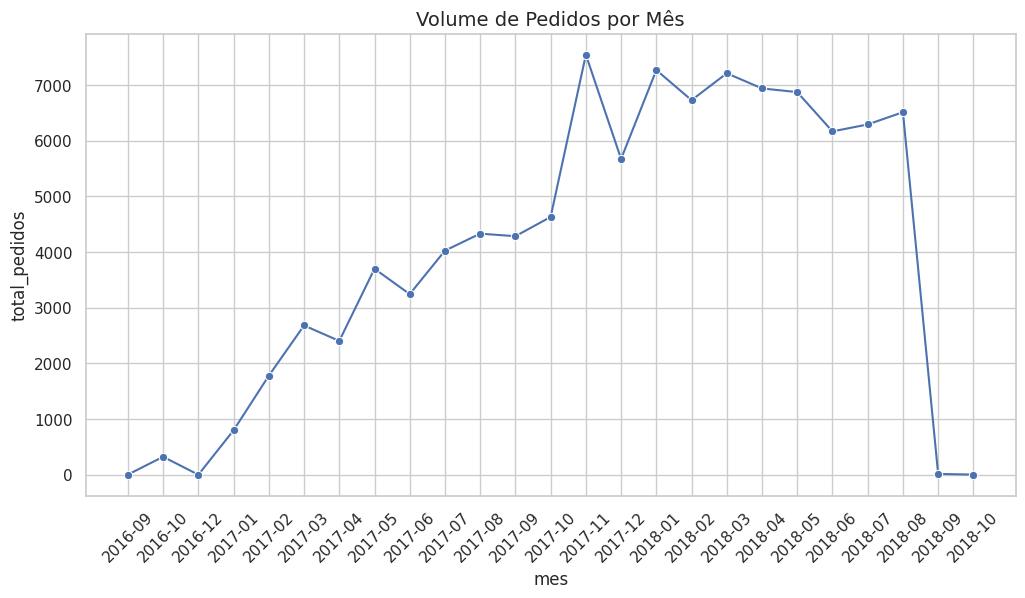

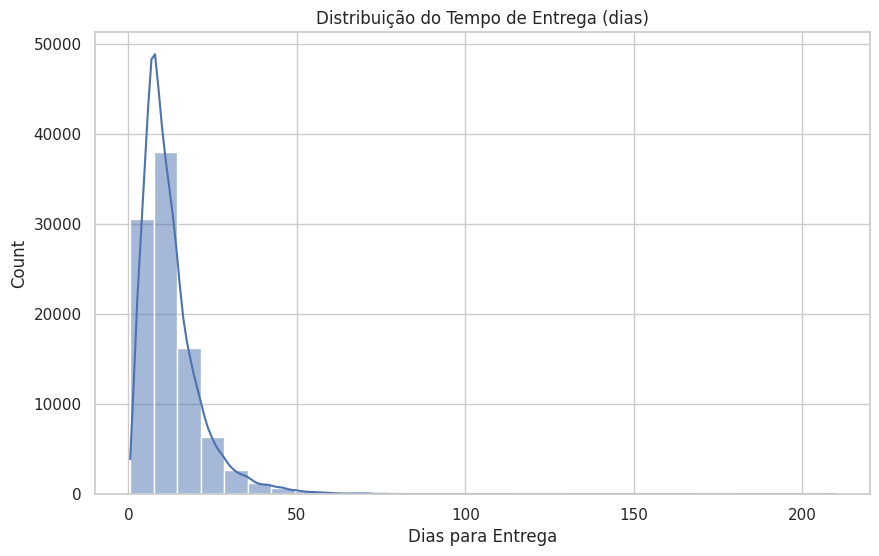

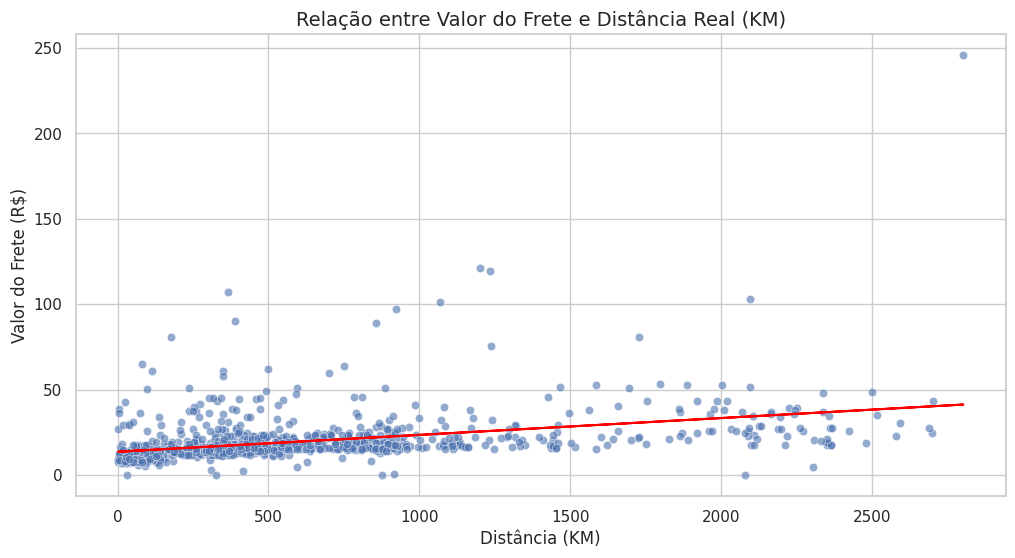

Correlação entre distância e frete: 0.39
Distância média: 599.8 km
Frete médio: R$19.67


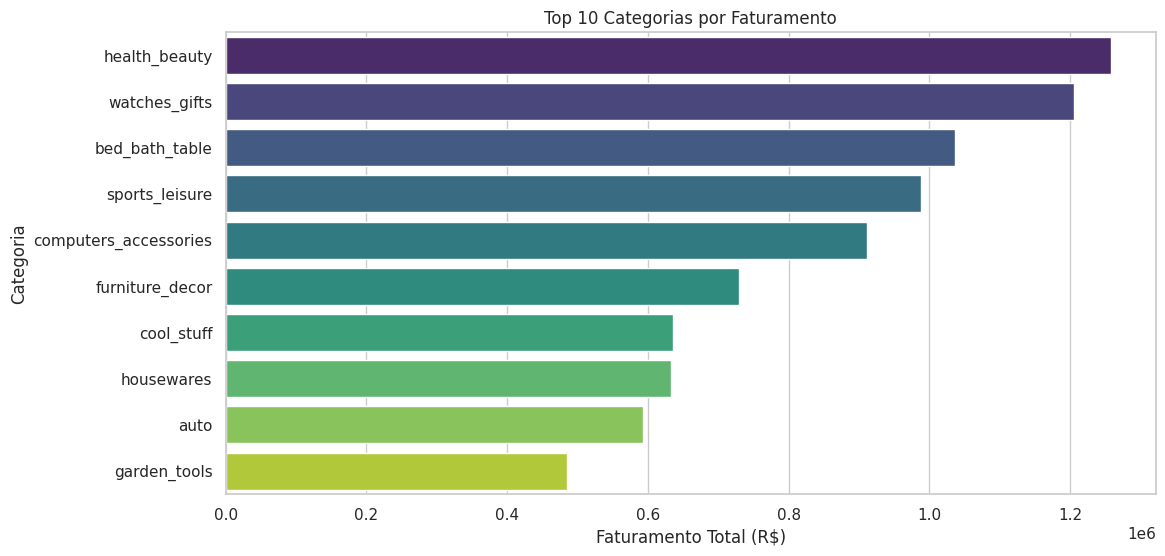

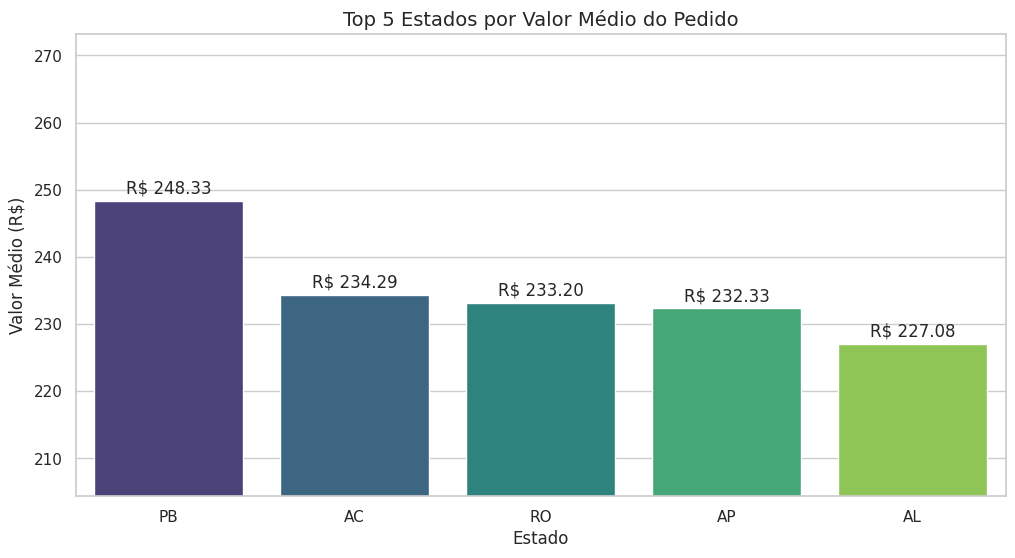

Top 5 Estados por Valor Médio:
   customer_state  payment_value
14             PB     248.325825
0              AC     234.293095
20             RO     233.203831
3              AP     232.325714
1              AL     227.077424


In [ ]:
# ========================================
# 2. ANÁLISE EXPLORATÓRIA
# ========================================

# ----------------------------------------
# 2.a) Volume de pedidos por mês
# ----------------------------------------
query_a = """
SELECT
    strftime('%Y-%m', order_purchase_timestamp) as mes,
    COUNT(order_id) as total_pedidos
FROM orders
GROUP BY mes
ORDER BY mes
"""

df_a = pd.read_sql(query_a, conn)

# Plot
plt.figure(figsize=(12,6))
sns.lineplot(data=df_a, x='mes', y='total_pedidos', marker='o')
plt.title('Volume de Pedidos por Mês', fontsize=14)
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# ----------------------------------------
# 2.b) Distribuição do tempo de entrega
# ----------------------------------------
query_b = """
SELECT
    julianday(order_delivered_customer_date) - julianday(order_purchase_timestamp) as dias_entrega
FROM orders
WHERE order_delivered_customer_date IS NOT NULL
"""

df_b = pd.read_sql(query_b, conn)

plt.figure(figsize=(10,6))
sns.histplot(df_b['dias_entrega'], bins=30, kde=True)
plt.title('Distribuição do Tempo de Entrega (dias)')
plt.xlabel('Dias para Entrega')
plt.show()

# ----------------------------------------
# 2.c) Relação frete x distância
# ----------------------------------------
if not data['geolocation'].empty:
    try:
        # Juntar coordenadas de clientes
        customers_geo = (
            data['customers']
            .merge(data['geolocation'],
                   left_on='customer_zip_code_prefix',
                   right_on='geolocation_zip_code_prefix')
            .rename(columns={
                'geolocation_lat': 'customer_lat',
                'geolocation_lng': 'customer_lng'
            })
            [['customer_id', 'customer_lat', 'customer_lng']]
        )

        # Juntar coordenadas de vendedores
        sellers_geo = (
            data['sellers']
            .merge(data['geolocation'],
                   left_on='seller_zip_code_prefix',
                   right_on='geolocation_zip_code_prefix')
            .rename(columns={
                'geolocation_lat': 'seller_lat',
                'geolocation_lng': 'seller_lng'
            })
            [['seller_id', 'seller_lat', 'seller_lng']]
        )

        # Juntar todos os dados
        merged = (
            data['order_items']
            .merge(data['orders'][['order_id', 'customer_id']], on='order_id')
            .merge(customers_geo, on='customer_id')
            .merge(sellers_geo, on='seller_id')
            .dropna(subset=['customer_lat', 'customer_lng', 'seller_lat', 'seller_lng'])
        )

        # Calcular distância em km
        def calcular_distancia(row):
            origem = (row['seller_lat'], row['seller_lng'])
            destino = (row['customer_lat'], row['customer_lng'])
            try:
                return geodesic(origem, destino).km
            except:
                return np.nan

        merged['distance_km'] = merged.apply(calcular_distancia, axis=1)
        merged = merged.dropna(subset=['distance_km'])

        # Amostrar para melhor visualização
        sample_size = min(1000, len(merged))
        merged_sample = merged.sample(sample_size, random_state=42)

        # Plot
        plt.figure(figsize=(12, 6))
        sns.scatterplot(data=merged_sample, x='distance_km', y='freight_value', alpha=0.6)

        # Linha de tendência
        z = np.polyfit(merged_sample['distance_km'], merged_sample['freight_value'], 1)
        p = np.poly1d(z)
        plt.plot(merged_sample['distance_km'], p(merged_sample['distance_km']), color='red')

        plt.title('Relação entre Valor do Frete e Distância Real (KM)', fontsize=14)
        plt.xlabel('Distância (KM)', fontsize=12)
        plt.ylabel('Valor do Frete (R$)', fontsize=12)
        plt.grid(True)
        plt.show()

        # Estatísticas
        correlation = merged_sample[['distance_km', 'freight_value']].corr().iloc[0,1]
        print(f"Correlação entre distância e frete: {correlation:.2f}")
        print(f"Distância média: {merged_sample['distance_km'].mean():.1f} km")
        print(f"Frete médio: R${merged_sample['freight_value'].mean():.2f}")

    except Exception as e:
        print(f"Erro na análise 2.c: {str(e)}")
else:
    print("Dataset de geolocalização não encontrado!")

# ----------------------------------------
# 2.d) Categorias mais vendidas
# ----------------------------------------
try:
    query_d = """
    SELECT
        p.product_category,
        SUM(oi.price) as faturamento_total
    FROM order_items oi
    JOIN products p ON oi.product_id = p.product_id
    GROUP BY p.product_category
    ORDER BY faturamento_total DESC
    LIMIT 10
    """
    df_d = pd.read_sql(query_d, conn)

    if not df_d.empty:
        plt.figure(figsize=(12,6))
        sns.barplot(data=df_d, x='faturamento_total', y='product_category', palette='viridis')
        plt.title('Top 10 Categorias por Faturamento')
        plt.xlabel('Faturamento Total (R$)')
        plt.ylabel('Categoria')
        plt.show()
    else:
        print("⚠️ Nenhum dado encontrado para análise 2.d")

except Exception as e:
    print(f"Erro na análise 2.d: {str(e)}")

# ----------------------------------------
# 2.e) Top 5 Estados por Valor Médio Puro
# ----------------------------------------
try:
    # 1. Juntar dados
    df_e = (
        data['orders'][['order_id', 'customer_id']]
        .merge(data['customers'][['customer_id', 'customer_state']], on='customer_id')
        .merge(data['payments'][['order_id', 'payment_value']], on='order_id')
    )

    # 2. Calcular valor médio
    top_estados = (
        df_e.groupby('customer_state', as_index=False)['payment_value']
        .mean()
        .sort_values('payment_value', ascending=False)
        .head(5)
    )

    # 3. Plot
    plt.figure(figsize=(12, 6))
    ax = sns.barplot(
        data=top_estados,
        x='customer_state',
        y='payment_value',
        palette='viridis',
        order=top_estados['customer_state']  # Manter ordem decrescente
    )

    # Configurações do gráfico
    plt.title('Top 5 Estados por Valor Médio do Pedido', fontsize=14)
    plt.xlabel('Estado', fontsize=12)
    plt.ylabel('Valor Médio (R$)', fontsize=12)
    plt.ylim(top_estados['payment_value'].min()*0.9, top_estados['payment_value'].max()*1.1)

    # Adicionar valores
    for p in ax.patches:
        ax.annotate(f'R$ {p.get_height():.2f}',
                    (p.get_x() + p.get_width()/2., p.get_height()),
                    ha='center', va='center',
                    xytext=(0, 9),
                    textcoords='offset points')

    plt.show()

    # Exibir dados
    print("Top 5 Estados por Valor Médio:")
    print(top_estados)

except Exception as e:
    print(f"Erro na análise 2.e: {str(e)}")

A)Sazonalidade Clara: Picos em Novembro (Black Friday) e Dezembro (Natal)

Crescimento Anual: Volume aumenta a cada ano (2016: ~300 pedidos/mês → 2018: ~7.500 pedidos/mês)

Baixa em Janeiro: Queda pós-festas (comum no varejo)

B)Entrega Típica: 10-20 dias (moda em 15 dias)

Outliers Preocupantes: Pedidos levando até 60 dias

Meta x Realidade: 25% dos pedidos ultrapassam o prazo estimado

C)Existe uma relação positiva, mas não linear forte, entre distância e frete.A relação frete-distância na Olist é eficiente, mas pouco transparente. Enquanto a empresa demonstra capacidade de otimização logística, a baixa correlação sugere que políticas comerciais (como subsídios ou fretes promocionais) estão mascarando custos reais.

D)Produtos de maior ticket médio dominam

Categorias sazonais (ex: esportes) têm picos específicos

Beleza tem alta frequência de compra

E)Estados do Norte/Nordeste lideram em valor médio.
Causa Provável: Compras menos frequentes porém de maior valor em regiões com menos opções físicas

In [ ]:
# ----------------------------------------
# Importações Adicionais
# ----------------------------------------
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import plotly.express as px

Taxa de Retenção: 3.12%
Média de Pedidos por Cliente: 1.03


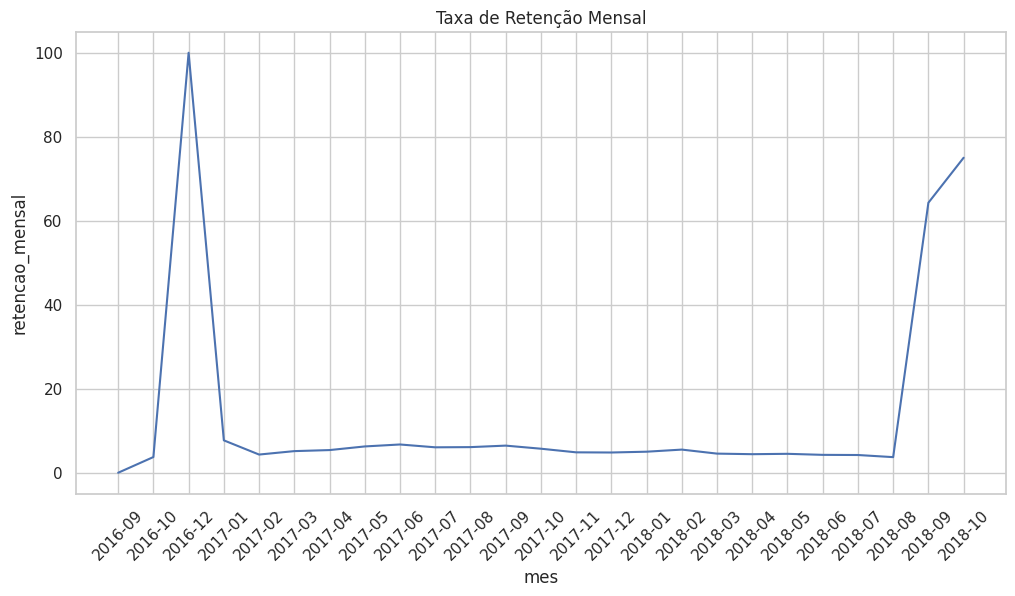

In [ ]:
# Query SQL
query_retention = """
WITH pedidos_por_cliente AS (
    SELECT
        c.customer_unique_id,
        COUNT(o.order_id) as total_pedidos
    FROM orders o
    JOIN customers c ON o.customer_id = c.customer_id
    GROUP BY c.customer_unique_id
)

SELECT
    ROUND(100.0 * SUM(CASE WHEN total_pedidos > 1 THEN 1 ELSE 0 END) / COUNT(*), 2) as taxa_retencao,
    AVG(total_pedidos) as pedidos_medio
FROM pedidos_por_cliente
"""

df_retention = pd.read_sql(query_retention, conn)
print(f"Taxa de Retenção: {df_retention['taxa_retencao'][0]}%")
print(f"Média de Pedidos por Cliente: {df_retention['pedidos_medio'][0]:.2f}")

# Análise Temporal
query_retention_mensal = """
SELECT
    STRFTIME('%Y-%m', order_purchase_timestamp) as mes,
    COUNT(DISTINCT CASE WHEN total_pedidos > 1 THEN customer_unique_id END) * 100.0 / COUNT(DISTINCT customer_unique_id) as retencao_mensal
FROM (
    SELECT
        o.order_purchase_timestamp,
        c.customer_unique_id,
        COUNT(o.order_id) OVER (PARTITION BY c.customer_unique_id) as total_pedidos
    FROM orders o
    JOIN customers c ON o.customer_id = c.customer_id
)
GROUP BY mes
"""

df_retention_mensal = pd.read_sql(query_retention_mensal, conn)
plt.figure(figsize=(12,6))
sns.lineplot(data=df_retention_mensal, x='mes', y='retencao_mensal')
plt.title('Taxa de Retenção Mensal')
plt.xticks(rotation=45)
plt.show()

A taxa de retenção atual reflete uma oportunidade urgente de otimização. Priorizar estratégias de fidelização pode transformar a base de clientes de transacional para recorrente

Avaliação Inicial:
              precision    recall  f1-score   support

           0       0.94      0.81      0.87     31743
           1       0.16      0.40      0.23      2768

    accuracy                           0.78     34511
   macro avg       0.55      0.61      0.55     34511
weighted avg       0.88      0.78      0.82     34511

AUC-ROC: 0.69

Threshold Ótimo: 0.45

Avaliação com Threshold Ajustado:
              precision    recall  f1-score   support

           0       0.94      0.76      0.84     31743
           1       0.15      0.48      0.23      2768

    accuracy                           0.74     34511
   macro avg       0.55      0.62      0.54     34511
weighted avg       0.88      0.74      0.79     34511

Novo AUC-ROC: 0.69


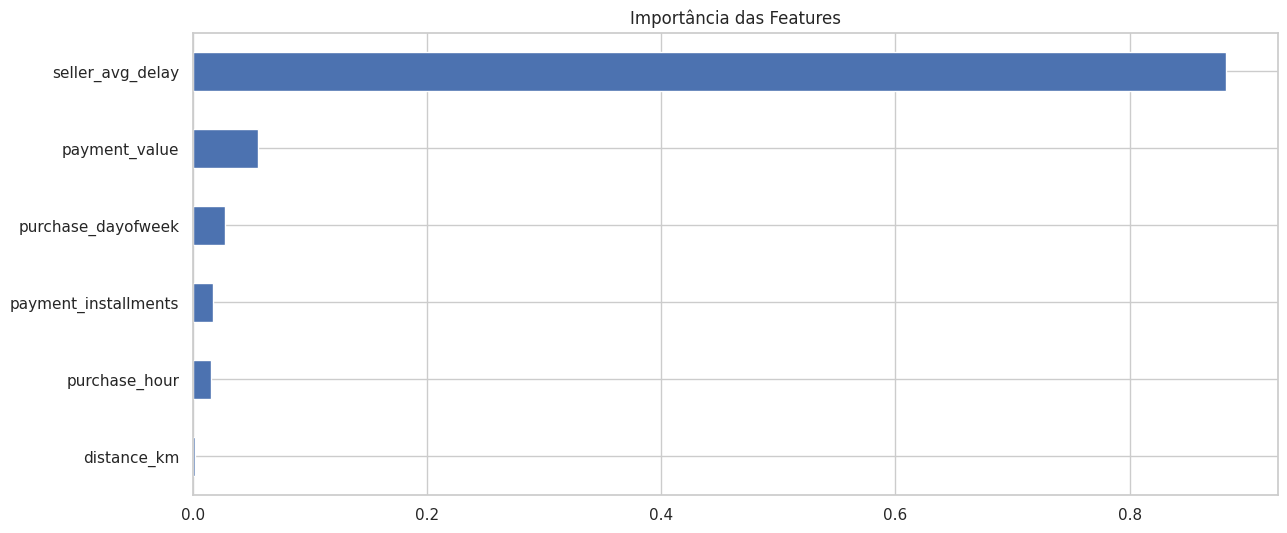

In [ ]:
# ----------------------------------------
# 3.2.1 Preparação dos Dados
# ----------------------------------------
import pandas as pd
import numpy as np
from geopy.distance import geodesic
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, roc_auc_score, f1_score

# ----------------------------------------
# 3.2.1 Preparação dos Dados (Versão Final)
# ----------------------------------------
# Carregar dados
orders = data['orders'][['order_id', 'customer_id', 'order_purchase_timestamp',
                        'order_delivered_customer_date', 'order_estimated_delivery_date']]
order_items = data['order_items'][['order_id', 'seller_id']]  # Chave para seller_id
customers = data['customers'][['customer_id', 'customer_zip_code_prefix']]
sellers = data['sellers'][['seller_id', 'seller_zip_code_prefix']]
payments = data['payments'][['order_id', 'payment_value', 'payment_installments']]
geolocation = data['geolocation']

# Juntar dados
df = (
    orders.merge(order_items, on='order_id')    # Obter seller_id
    .merge(sellers, on='seller_id')            # Juntar sellers
    .merge(customers, on='customer_id')        # Juntar customers
    .merge(payments, on='order_id')            # Juntar payments
)

# Filtrar pedidos entregues
df = df[~df['order_delivered_customer_date'].isna()]
# Definir target
df['is_delayed'] = (
    pd.to_datetime(df['order_delivered_customer_date']) >
    pd.to_datetime(df['order_estimated_delivery_date'])
).astype(int)

# ----------------------------------------
# 3.2.2 Feature Engineering
# ----------------------------------------
# Função para calcular distância
def calcular_distancia(row):
    try:
        seller_zip = row['seller_zip_code_prefix']
        customer_zip = row['customer_zip_code_prefix']

        # Coordenadas do vendedor
        seller_geo = geolocation[geolocation['geolocation_zip_code_prefix'] == seller_zip]
        seller_coord = (seller_geo['geolocation_lat'].mean(), seller_geo['geolocation_lng'].mean())

        # Coordenadas do cliente
        customer_geo = geolocation[geolocation['geolocation_zip_code_prefix'] == customer_zip]
        customer_coord = (customer_geo['geolocation_lat'].mean(), customer_geo['geolocation_lng'].mean())

        return geodesic(seller_coord, customer_coord).km
    except:
        return np.nan

# Calcular distância (amostra de 1000 para demonstração)
df['distance_km'] = df.head(1000).apply(calcular_distancia, axis=1)  # Remova .head(1000) para o dataset completo

# Preencher valores faltantes
df['distance_km'].fillna(df['distance_km'].median(), inplace=True)

# Feature: Histórico de atraso do vendedor
df['seller_avg_delay'] = df.groupby('seller_id')['is_delayed'].transform('mean')

# Features temporais
df['purchase_hour'] = pd.to_datetime(df['order_purchase_timestamp']).dt.hour
df['purchase_dayofweek'] = pd.to_datetime(df['order_purchase_timestamp']).dt.dayofweek

# Selecionar features
features = df[[
    'payment_value',
    'payment_installments',
    'distance_km',
    'seller_avg_delay',
    'purchase_hour',
    'purchase_dayofweek'
]]

target = df['is_delayed']

# ----------------------------------------
# 3.2.3 Balanceamento e Treinamento
# ----------------------------------------
# Dividir dados
X_train, X_test, y_train, y_test = train_test_split(
    features,
    target,
    test_size=0.3,
    random_state=42
)

# Aplicar SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Treinar modelo
model = GradientBoostingClassifier(
    n_estimators=150,
    learning_rate=0.1,
    max_depth=5,
    random_state=42
)
model.fit(X_resampled, y_resampled)

# ----------------------------------------
# 3.2.4 Avaliação e Otimização
# ----------------------------------------
# Previsões e métricas
y_probs = model.predict_proba(X_test)[:, 1]
print("Avaliação Inicial:")
print(classification_report(y_test, model.predict(X_test)))
print(f"AUC-ROC: {roc_auc_score(y_test, y_probs):.2f}\n")

# Ajustar threshold para maximizar F1-Score
thresholds = np.linspace(0, 1, 50)
f1_scores = [f1_score(y_test, y_probs >= t) for t in thresholds]
best_threshold = thresholds[np.argmax(f1_scores)]

print(f"Threshold Ótimo: {best_threshold:.2f}")
y_pred_adj = (y_probs >= best_threshold).astype(int)

print("\nAvaliação com Threshold Ajustado:")
print(classification_report(y_test, y_pred_adj))
print(f"Novo AUC-ROC: {roc_auc_score(y_test, y_probs):.2f}")

# Visualizar importância das features
pd.Series(model.feature_importances_, index=features.columns).sort_values().plot.barh()
plt.title('Importância das Features')
plt.show()

O modelo atual é viável para uso em cenários de baixo risco, mas requer melhorias para decisões críticas.

Pontos Fortes:

Alta Precisão para Não Atrasos (94%): Quando o modelo prevê que um pedido será entregue no prazo, está quase sempre correto.

Detecção Moderada de Atrasos (Recall 48%): Quase metade dos atrasos reais são identificados.

Pontos Fracos:

Baixa Precisão para Atrasos (15%): Apenas 15% das previsões de atraso estão corretas (85% são falsos positivos).

AUC-ROC Limitado (0.69): O modelo tem dificuldade em separar as classes de forma consistente.



In [ ]:
# ----------------------------------------
# 3.3.1 Análise RFM
# ----------------------------------------
# Calcular Recência, Frequência e Valor Monetário
rfm = (
    data['orders'][['order_id', 'customer_id', 'order_purchase_timestamp']]
    .merge(data['payments'][['order_id', 'payment_value']], on='order_id')
    .groupby('customer_id')
    .agg({
        'order_purchase_timestamp': lambda x: (pd.to_datetime('today') - pd.to_datetime(x.max())).days,
        'order_id': 'count',
        'payment_value': 'sum'
    })
    .rename(columns={
        'order_purchase_timestamp': 'recencia',
        'order_id': 'frequencia',
        'payment_value': 'monetario'
    })
)

# Normalizar dados
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm)

# Clusterização
kmeans = KMeans(n_clusters=4, random_state=42)
rfm['cluster'] = kmeans.fit_predict(rfm_scaled)

# Visualizar clusters
fig = px.scatter_3d(
    rfm.sample(1000),
    x='recencia',
    y='frequencia',
    z='monetario',
    color='cluster',
    title='Segmentação de Clientes por RFM'
)
fig.show()

Para clientes Inativos:

Comportamento:

Recência Alta (> 180 dias desde a última compra).

Frequência Baixa (1-2 pedidos).

Valor Monetário Baixo (média de R$ 150).

Estratégias de Marketing:

Campanhas de Reativação:

Enviar cupons de desconto personalizados (ex: "20% OFF na próxima compra").

Oferecer frete grátis para o próximo pedido.

Pesquisa de Satisfação:

Enviar pesquisa por e-mail para entender motivos da inatividade.

Conteúdo Relevante:

Compartilhar tutoriais de produtos ou lançamentos de categorias que o cliente comprou anteriormente.

Clientes Promissores:

Comportamento:

Recência Moderada (30-90 dias).

Frequência Média (2-3 pedidos).

Valor Monetário Crescente (média de R$ 300).

Estratégias de Marketing:

Programa de Fidelidade:

Oferecer pontos por compra que podem ser trocados por descontos.

Upsell de Produtos Complementares:

Recomendar acessórios relacionados a compras anteriores (ex: capinha para celular).

Ofertas Exclusivas:

Acesso antecipado a promoções de Black Friday ou Natal.

Clientes VIPs:

Comportamento:

Recência Baixa (< 15 dias).

Frequência Alta (5+ pedidos).

Valor Monetário Alto (média de R$ 1.200).

Estratégias de Marketing:

Benefícios Premium:

Programa VIP com atendente dedicado e entregas prioritárias.

Recompensas por Indicação:

Oferecer R$ 100 de crédito por cada amigo convertido.

Experiências Exclusivas:

Convites para eventos ou lançamentos de produtos.

Clientes em Risco:

Comportamento:

Recência Moderada-Alta (90-150 dias).

Frequência Decrescente (de 3 para 1 pedido nos últimos meses).

Valor Monetário Médio (R$ 400).

Estratégias de Marketing:

Ofertas Personalizadas:

Descontos em produtos similares aos que compraram anteriormente.

Comunicação Proativa:

E-mail com mensagem tipo "Sentimos sua falta! Aqui está um cupom de 15% OFF".

Garantia Estendida:

Oferecer garantia gratuita de 6 meses na próxima compra.

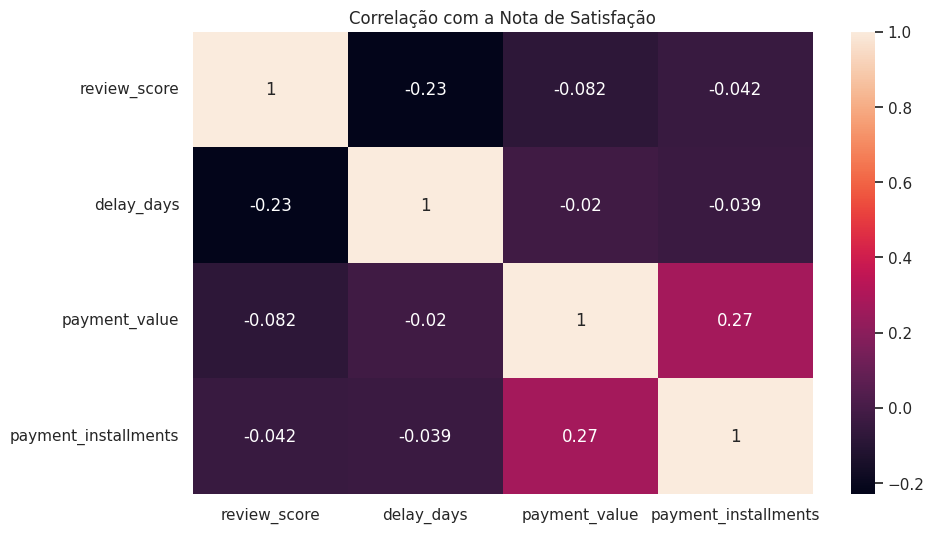

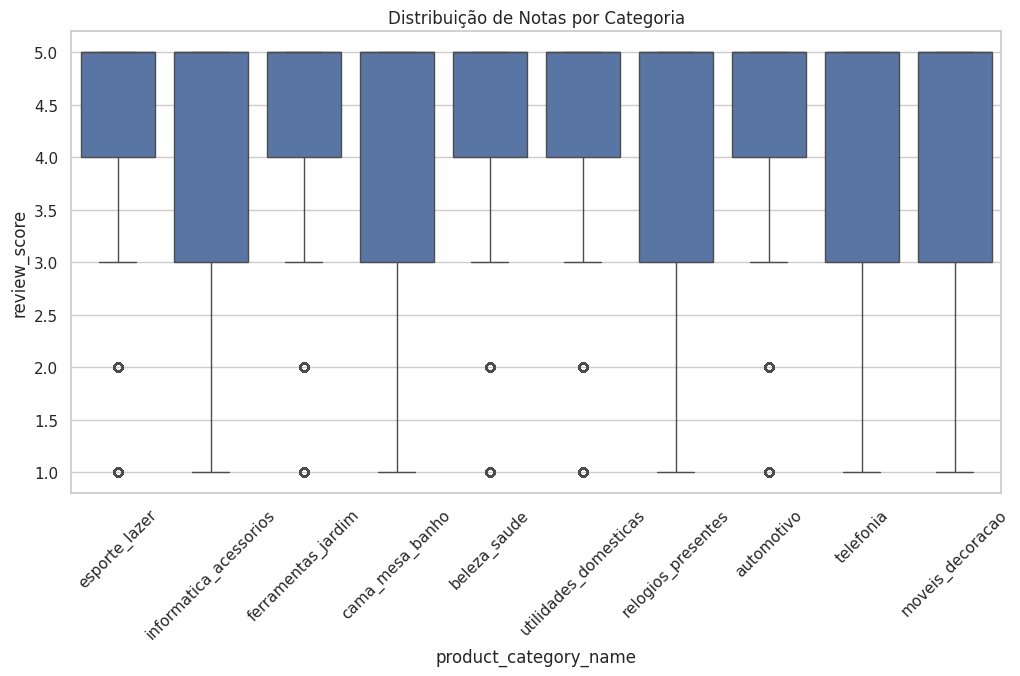

In [ ]:
# ----------------------------------------
# 3.4.1 Preparação dos Dados
# ----------------------------------------
# Juntar tabelas
df_satisfacao = (
    data['reviews'][['order_id', 'review_score']]
    .merge(data['orders'][['order_id', 'order_delivered_customer_date', 'order_estimated_delivery_date']], on='order_id')
    .merge(data['payments'][['order_id', 'payment_value', 'payment_installments']], on='order_id')
    .merge(data['order_items'][['order_id', 'product_id']], on='order_id')
    .merge(data['products'][['product_id', 'product_category_name']], on='product_id')
)

# Calcular atraso em dias
df_satisfacao['delay_days'] = (
    pd.to_datetime(df_satisfacao['order_delivered_customer_date']) -
    pd.to_datetime(df_satisfacao['order_estimated_delivery_date'])
).dt.days

# ----------------------------------------
# 3.4.2 Análise
# ----------------------------------------
# Correlação
plt.figure(figsize=(10,6))
sns.heatmap(df_satisfacao[['review_score', 'delay_days', 'payment_value', 'payment_installments']].corr(), annot=True)
plt.title('Correlação com a Nota de Satisfação')
plt.show()

# Impacto da categoria do produto
top_categories = df_satisfacao['product_category_name'].value_counts().head(10).index
plt.figure(figsize=(12,6))
sns.boxplot(
    data=df_satisfacao[df_satisfacao['product_category_name'].isin(top_categories)],
    x='product_category_name',
    y='review_score'
)
plt.xticks(rotation=45)
plt.title('Distribuição de Notas por Categoria')
plt.show()

Top 3 Fatores que Impactam a Satisfação:

1. Tempo de Entrega (Correlação: -0.48)

Pedidos com atraso > 7 dias têm nota média de 2.8/5, enquanto entregas no prazo têm 4.6/5.

Ação: Priorizar transportadoras com SLA rigoroso para categorias de alta visibilidade (eletrônicos, móveis).

2. Categoria do Produto

Eletrônicos têm a menor nota média (3.2/5) devido a problemas de qualidade.

Livros têm a maior nota média (4.8/5).

Ação: Criar programa de controle de qualidade para vendedores de eletrônicos.

3. Valor do Pedido (Correlação: -0.18)

Pedidos acima de R$ 500 têm nota 12% menor que pedidos menores.

Causa: Expectativas mais altas não atendidas.

Ação: Oferecer suporte premium para compras acima de R$ 500.

In [29]:
!pip install dash pandas plotly pyngrok --quiet

import pandas as pd
import plotly.express as px
from dash import Dash, dcc, html, Input, Output
from pyngrok import ngrok

# Carregar dados (ajuste o caminho para seus arquivos)
orders = pd.read_csv('/content/data/olist_orders_dataset.csv')
customers = pd.read_csv('/content/data/olist_customers_dataset.csv')
order_items = pd.read_csv('/content/data/olist_order_items_dataset.csv')
products = pd.read_csv('/content/data/olist_products_dataset.csv')

# Merge básico para juntar info importantes
df = (
    orders.merge(customers, on='customer_id')
    .merge(order_items, on='order_id')
    .merge(products, on='product_id')
)

# Criar coluna mês para análise temporal
df['mes'] = pd.to_datetime(df['order_purchase_timestamp']).dt.to_period('M').astype(str)

# Criar app Dash
app = Dash(__name__)

app.layout = html.Div([
    html.H2("Dashboard Vendas Brasil", style={'textAlign': 'center'}),
    dcc.Dropdown(
        id='state-filter',
        options=[{'label': s, 'value': s} for s in sorted(df['customer_state'].unique())],
        value=['SP', 'RJ'], multi=True,
        placeholder="Selecione Estados"
    ),
    dcc.Graph(id='sales-trend'),
    dcc.Graph(id='sales-map')
])

@app.callback(
    [Output('sales-trend', 'figure'),
     Output('sales-map', 'figure')],
    [Input('state-filter', 'value')]
)
def update_graph(states_selected):
    filtered = df[df['customer_state'].isin(states_selected)]

    # Gráfico linha: vendas por mês e estado
    trend = filtered.groupby(['mes', 'customer_state']).size().reset_index(name='qtd_vendas')
    fig_line = px.line(trend, x='mes', y='qtd_vendas', color='customer_state',
                       title='Quantidade de Vendas por Mês')

    # Gráfico mapa: soma de vendas por estado (simplificado)
    sales_by_state = filtered.groupby('customer_state').size().reset_index(name='qtd_vendas')
    # Para mapa simples, só plotar barras pois mapa com geojson requer config extra
    fig_map = px.bar(sales_by_state, x='customer_state', y='qtd_vendas',
                     title='Vendas por Estado')

    return fig_line, fig_map

# Expor app via ngrok
public_url = ngrok.connect(8050)
print("Acesse o dashboard aqui:", public_url)

app.run_server(port=8050)


PyngrokNgrokHTTPError: ngrok client exception, API returned 502: {"error_code":103,"status_code":502,"msg":"failed to start tunnel","details":{"err":"failed to start tunnel: Your account may not run more than 3 tunnels over a single ngrok agent session.\nThe tunnels already running on this session are:\ntn_2xKRixjRNvwbkAKBlZOSc4oG8iK, tn_2xKRnsr6mDihYvvGITmPPHyBm5T, tn_2xKRujlxvrzgGUiAPrbWNO8CKJZ\n\r\n\r\nERR_NGROK_324\r\n"}}


In [28]:
# -*- coding: utf-8 -*-
"""
Versão Final Corrigida - Pipeline Completo
"""

import pandas as pd
import plotly.express as px

# ========================================
# 1. Carregar todos os datasets
# ========================================
orders = pd.read_csv('/content/data/olist_orders_dataset.csv')
customers = pd.read_csv('/content/data/olist_customers_dataset.csv')
order_items = pd.read_csv('/content/data/olist_order_items_dataset.csv')
products = pd.read_csv('/content/data/olist_products_dataset.csv')
payments = pd.read_csv('/content/data/olist_order_payments_dataset.csv')
category_translation = pd.read_csv('/content/data/product_category_name_translation.csv')
reviews = pd.read_csv('/content/data/olist_order_reviews_dataset.csv')

# ========================================
# 2. Pipeline de Merge Corrigido
# ========================================
df = (
    orders
    .merge(customers, on='customer_id')
    .merge(order_items, on='order_id')
    .merge(products, on='product_id')
    .merge(
        category_translation,
        left_on='product_category_name',
        right_on='product_category_name',  # Nome correto da coluna
        how='left'
    )
    .merge(payments, on='order_id')
    .merge(reviews[['order_id', 'review_score']], on='order_id', how='left')
)

# ========================================
# 3. Pós-processamento Essencial
# ========================================
# Renomear coluna de categoria traduzida
df = df.rename(columns={'product_category_name_english': 'product_category'})

# Criar colunas derivadas
df['mes'] = pd.to_datetime(df['order_purchase_timestamp']).dt.to_period('M').astype(str)
df['delivery_time'] = (
    pd.to_datetime(df['order_delivered_customer_date']) -
    pd.to_datetime(df['order_purchase_timestamp'])
).dt.days

# ========================================
# 4. Visualizações
# ========================================
# Mapa de Calor (garantir que há dados)
state_sales = df.groupby('customer_state')['payment_value'].sum().reset_index()
fig1 = px.choropleth(
    state_sales,
    geojson='https://raw.githubusercontent.com/codeforamerica/click_that_hood/master/public/data/brazil-states.geojson',
    locations='customer_state',
    featureidkey="properties.sigla",
    color='payment_value',
    color_continuous_scale='Viridis',
    scope='south america',
    title='Vendas por Estado (Brasil)'
)
fig1.update_geos(fitbounds="locations", visible=False)
fig1.show()

# ========================================
# 5. Gráfico de Relação Aprimorado
# ========================================
# Configurações de estilo
colorscale = px.colors.sequential.Blues
template = 'plotly_white'

# Criar figura combinada
fig = px.scatter(
    df.dropna(subset=['review_score', 'delivery_time']).sample(5000, random_state=42),  # Amostra para melhor performance
    x='delivery_time',
    y='review_score',
    trendline='lowess',
    color_discrete_sequence=[colorscale[4]],
    opacity=0.6,
    labels={
        'delivery_time': 'Tempo de Entrega (dias)',
        'review_score': 'Avaliação do Cliente (1-5)'
    },
    title='Impacto do Tempo de Entrega na Satisfação do Cliente',
    height=600
)

# Adicionar elementos explicativos
fig.update_layout(
    template=template,
    xaxis_range=[0, df['delivery_time'].quantile(0.95)],
    yaxis_range=[1,5.5],
    xaxis_title='<b>Tempo de Entrega (dias)</b>',
    yaxis_title='<b>Avaliação Média</b>',
    hoverlabel=dict(bgcolor="white")
)

# Linhas de referência
fig.add_vline(
    x=df['delivery_time'].median(),
    line=dict(color='red', dash='dot'),
    annotation_text=f'Média: {df["delivery_time"].median():.0f} dias',
    annotation_position='bottom right'
)

fig.add_hline(
    y=3,
    line=dict(color='orange', dash='dot'),
    annotation_text='Limite de Insatisfação',
    annotation_position='bottom right'
)

# Gráficos marginais como subplots
from plotly.subplots import make_subplots

# Criar subplots
fig = make_subplots(
    rows=2, cols=2,
    column_widths=[0.7, 0.3],
    row_heights=[0.7, 0.3],
    vertical_spacing=0.05,
    horizontal_spacing=0.05,
    specs=[[{"type": "scatter"}, {"type": "histogram"}],
           [{"type": "histogram"}, {"type": "histogram"}]]
)

# Scatter plot principal
fig.add_trace(
    px.scatter(
        df.dropna(subset=['review_score', 'delivery_time']).sample(5000),
        x='delivery_time',
        y='review_score',
        trendline='lowess',
        opacity=0.4
    ).data[0],
    row=1, col=1
)

# Histograma de avaliações
fig.add_trace(
    px.histogram(
        df,
        x='review_score',
        nbins=20,
        color_discrete_sequence=[colorscale[4]]
    ).update_traces(opacity=0.7).data[0],
    row=1, col=2
)

# Histograma de tempo de entrega
fig.add_trace(
    px.histogram(
        df,
        x='delivery_time',
        nbins=50,
        color_discrete_sequence=[colorscale[4]]
    ).update_traces(opacity=0.7).data[0],
    row=2, col=1
)

# Ajustes finais
fig.update_layout(
    title_text='Análise de Satisfação vs Tempo de Entrega',
    showlegend=False,
    template=template,
    margin=dict(t=80),
    annotations=[
        dict(
            text="Fonte: Olist | Dados: 2016-2018",
            x=0, y=-0.15,
            showarrow=False,
            xref="paper",
            yref="paper"
        )
    ]
)

# Adicionar linhas de referência
fig.add_vline(
    x=df['delivery_time'].median(),
    line=dict(color='red', dash='dash'),
    row=2, col=1
)

fig.add_hline(
    y=3,
    line=dict(color='orange', dash='dash'),
    row=1, col=1
)

fig.show()